In [110]:
import numpy as np
import librosa
from multiprocessing import Pool
import pandas as pd
import psutil
import os
import threading
import time
import csv
from tqdm import tqdm
import gc
import os

BLOCKSIZE = 0.05
MEMORY_SAMPLING_INTERVAL = 3
NUM_CHUNKS = 2
DB_THRESHOLD = 50
audio_file = "nicht_zu_laut_abspielen.wav"

def analyze_audio_block(block):

    # Get the current block
    y_block, idx = block

    if len(y_block) < BLOCKSIZE:
        # Letzter Block könnte kürzer als die Blockgröße sein
        return None

    # Berechnung der Fourier-Transformierten
    Y = np.fft.fft(y_block)
    Y_magnitude = np.abs(Y)[: BLOCKSIZE // 2]
    Y_db = librosa.amplitude_to_db(Y_magnitude, ref=np.max)
    major_frequencies = np.where(Y_db > DB_THRESHOLD)[0]

    # Berechnung der statistischen Werte
    mean_val = np.mean(Y_magnitude)
    std_val = np.std(Y_magnitude)
    quantiles = np.percentile(Y_magnitude, [25, 50, 75])

    # Speichern der Statistiken
    stats = {
        "block_start": idx,
        "mean": mean_val,
        "std": std_val,
        "25th_percentile": quantiles[0],
        "50th_percentile": quantiles[1],
        "75th_percentile": quantiles[2],
        "major_frequenzies": major_frequencies,
    }

    return stats

In [111]:
import matplotlib.pyplot as plt
from scipy.io import wavfile



sr, y = wavfile.read(audio_file)
y = y[:, 0]
pos = 0
time_window = 0.05  # 50ms window
sample_window = int(sr * time_window)
start = max(0, pos - sample_window // 2)
end = min(len(y), start + sample_window)

selected_samples = y[start:end]

# Berechnung der Fourier-Transformierten
N = len(selected_samples)
yf = np.fft.fft(selected_samples)
xf = np.linspace(0.0, sr / 2.0, N // 2)
magnitude = 2.0 / N * np.abs(yf[: N // 2])
magnitude_db = 20 * np.log10(magnitude)
max_magnitudes = np.sort(magnitude_db)[::-1]
max_indices = np.argsort(magnitude_db)[::-1]
# to_index should be the first index where the magnitude is smaller than the threshold
to_index = np.where(magnitude_db < DB_THRESHOLD)[0][0]
for i in range(to_index):
    print(f"{xf[max_indices[i]]} Hz: {magnitude_db[max_indices[i]]} dB")
    


40.05449591280654 Hz: 81.02354864357599 dB
440.59945504087193 Hz: 70.52246895676262 dB
60.0817438692098 Hz: 62.31807653194946 dB
4005.4495912806537 Hz: 61.18556457615993 dB
20.02724795640327 Hz: 58.356015228860336 dB
100.13623978201635 Hz: 57.830509576827126 dB
80.10899182561307 Hz: 54.7453345592687 dB
120.1634877384196 Hz: 53.44456102549919 dB
140.19073569482288 Hz: 53.195133308724884 dB


In [116]:
import pandas as pd

df = pd.read_csv("statistics.csv", header=None, names=["block_start", "block_end", "main_frequencies"])
df

,block_start,block_end,main_frequencies
0,0,2205,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
1,1,2206,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
2,2,2207,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
3,3,2208,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
4,4,2209,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
...,...,...,...
1322443,1322443,1324648,"[(40, 80), (440, 70), (80, 65), (60, 64), (400..."
1322444,1322444,1324649,"[(40, 80), (440, 70), (80, 65), (60, 64), (400..."
1322445,1322445,1324650,"[(40, 80), (440, 70), (80, 65), (60, 64), (400..."
1322446,1322446,1324651,"[(40, 80), (440, 70), (80, 65), (60, 64), (400..."


In [117]:
df.head()

,block_start,block_end,main_frequencies
0,0,2205,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
1,1,2206,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
2,2,2207,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
3,3,2208,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."
4,4,2209,"[(40, 81), (440, 70), (60, 62), (4005, 61), (2..."


In [118]:
def convert_string_to_list_of_tuples(s):
    s = s.replace("[", "").replace("]", "").replace("'", "")
    tuple_splits = s.split("),")
    freqs = []
    magns = []
    for t in tuple_splits:
        t = t.replace("(", "").replace(")", "")
        t = t.split(",")
        freqs.append(int(t[0])) 
        magns.append(int(t[1]))
    return freqs, magns

<BarContainer object of 6 artists>

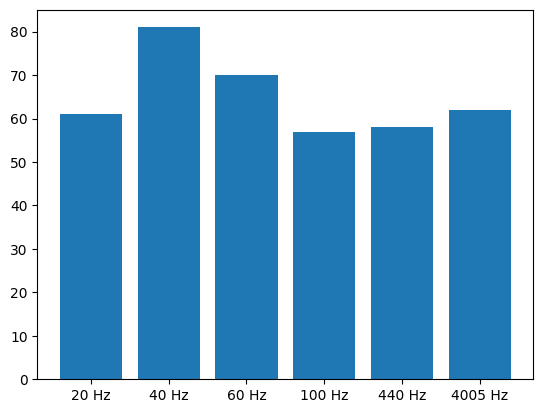

In [125]:
import matplotlib.pyplot as plt
row = df.iloc[0]
freqs, magns = convert_string_to_list_of_tuples(row["main_frequencies"])
np.argsort(freqs)
freqs = [f"{freqs[i]} Hz" for i in np.argsort(freqs)]
magns = [magns[i] for i in np.argsort(freqs)]
plt.bar(freqs, magns)